In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.8 MB/s eta 0:00:00


In [2]:
!pip install -q datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.5 MB/s eta 0:00:00


In [1]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("./layoutlmv3.py")

c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 10
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 2
    })
})

In [3]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['invoice_no', 'date', 'amount'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None)}

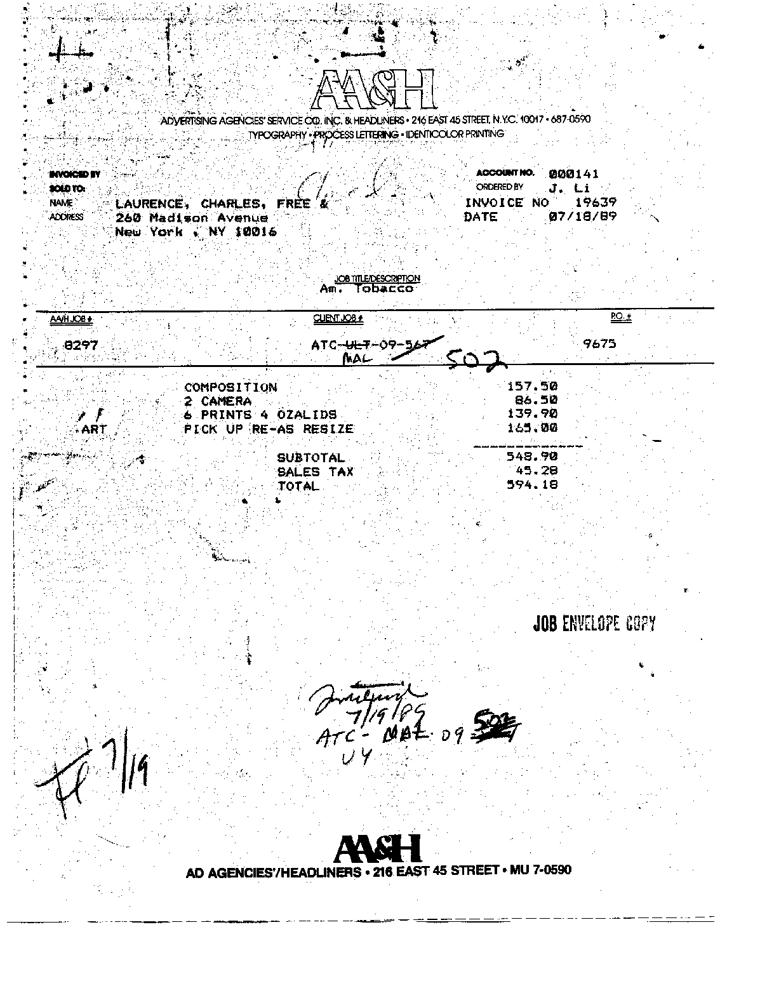

In [4]:
example = dataset["train"][0]
example["image"]

In [5]:
qq = example["image"].convert("RGB")
qq.size

(762, 1000)

In [7]:
from  PIL import Image
qqq = Image.open(r"C:/Users/TirocinioMatteo/Desktop/Matteo/Python_3/Vai/ai/PDF/LayoutLMv3/doc/06628fa4-invoice_1.jpg").convert("RGB")
qqq.size


(754, 1000)

In [8]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)



['socio', 'INVOICE', 'NO”', '19639', 'e7/ie/ay']
[[665, 480, 732, 489], [611, 198, 686, 207], [699, 198, 720, 207], [755, 197, 809, 207], [720, 211, 809, 222]]
[2, 0, 0, 0, 1]


In [9]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [10]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [11]:
print(label_list)

['invoice_no', 'date', 'amount']


In [12]:
print(id2label)

{0: 'invoice_no', 1: 'date', 2: 'amount'}


In [13]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [14]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map: 100%|██████████| 2/2 [00:00<00:00, 38.39 examples/s]


In [15]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 10
})

In [16]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> socio INVOICE NO” 19639 e7/ie/ay</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [17]:
train_dataset.set_format("torch")

In [18]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [19]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 2
})

In [20]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> 3022-9461] 4/13/95] 4/20/99] 4/17/95 4/17/95] tia,__047503.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [21]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 socio 2
 IN 0
VO -100
ICE -100
 NO 0
� -100
� -100
 196 0
39 -100
 e 1
7 -100
/ -100
ie -100
/ -100
ay -100
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pa

In [24]:
from datasets import load_metric

metric = load_metric("seqeval", trust_remote_code=True)

In [25]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [26]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\transformers\training_args.py:1504: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# !pip install accelerate -U

In [28]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [29]:
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\transformers\modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|█         | 100/1000 [20:12<3:08:27, 12.56s/it]c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: invoice_no seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: amount seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
                                                    
 10%|█         

{'eval_loss': 0.24011613428592682, 'eval_precision': 0.6666666666666666, 'eval_recall': 0.6666666666666666, 'eval_f1': 0.6666666666666666, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 5.9016, 'eval_samples_per_second': 0.339, 'eval_steps_per_second': 0.169, 'epoch': 20.0}


                                                    
 20%|██        | 200/1000 [41:50<2:49:44, 12.73s/it]

{'eval_loss': 0.20822791755199432, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.8349, 'eval_samples_per_second': 0.343, 'eval_steps_per_second': 0.171, 'epoch': 40.0}


                                                      
 30%|███       | 300/1000 [1:02:45<2:23:14, 12.28s/it]

{'eval_loss': 0.17518025636672974, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.6603, 'eval_samples_per_second': 0.353, 'eval_steps_per_second': 0.177, 'epoch': 60.0}


                                                      
 40%|████      | 400/1000 [1:23:58<2:02:40, 12.27s/it]

{'eval_loss': 0.16332043707370758, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.7069, 'eval_samples_per_second': 0.35, 'eval_steps_per_second': 0.175, 'epoch': 80.0}


 50%|█████     | 500/1000 [1:46:15<1:52:07, 13.46s/it]

{'loss': 0.0253, 'grad_norm': 0.007859802804887295, 'learning_rate': 5e-06, 'epoch': 100.0}


                                                      
 50%|█████     | 500/1000 [1:46:21<1:52:07, 13.46s/it]

{'eval_loss': 0.15697349607944489, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.9832, 'eval_samples_per_second': 0.334, 'eval_steps_per_second': 0.167, 'epoch': 100.0}


c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\transformers\modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 60%|██████    | 600/1000 [2:08:04<1:30:58, 13.65s/it]c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: invoice_no seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: amount seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
                                                      
 60%|██████    | 600/1000 [2:08:10<1:30:58, 13.65s/

{'eval_loss': 0.1481906920671463, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 6.0502, 'eval_samples_per_second': 0.331, 'eval_steps_per_second': 0.165, 'epoch': 120.0}


                                                      
 70%|███████   | 700/1000 [2:29:51<1:07:22, 13.47s/it]

{'eval_loss': 0.14472168684005737, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.8542, 'eval_samples_per_second': 0.342, 'eval_steps_per_second': 0.171, 'epoch': 140.0}


                                                      
 80%|████████  | 800/1000 [2:50:58<42:03, 12.62s/it]

{'eval_loss': 0.14455260336399078, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.8988, 'eval_samples_per_second': 0.339, 'eval_steps_per_second': 0.17, 'epoch': 160.0}


                                                    
 90%|█████████ | 900/1000 [3:12:44<20:39, 12.40s/it]

{'eval_loss': 0.14099963009357452, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.6563, 'eval_samples_per_second': 0.354, 'eval_steps_per_second': 0.177, 'epoch': 180.0}


100%|██████████| 1000/1000 [3:33:14<00:00, 12.00s/it]

{'loss': 0.0001, 'grad_norm': 0.003710799850523472, 'learning_rate': 0.0, 'epoch': 200.0}


                                                     
100%|██████████| 1000/1000 [3:33:19<00:00, 12.00s/it]

{'eval_loss': 0.1410137265920639, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.3944, 'eval_samples_per_second': 0.371, 'eval_steps_per_second': 0.185, 'epoch': 200.0}


100%|██████████| 1000/1000 [3:33:22<00:00, 12.80s/it]

{'train_runtime': 12802.7383, 'train_samples_per_second': 0.156, 'train_steps_per_second': 0.078, 'train_loss': 0.012714431166648865, 'epoch': 200.0}


TrainOutput(global_step=1000, training_loss=0.012714431166648865, metrics={'train_runtime': 12802.7383, 'train_samples_per_second': 0.156, 'train_steps_per_second': 0.078, 'total_flos': 527191787520000.0, 'train_loss': 0.012714431166648865, 'epoch': 200.0})

In [30]:
trainer.evaluate()

c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\transformers\modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: invoice_no seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\TirocinioMatteo\.miniconda\envs\PDF\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: amount seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


{'eval_loss': 0.15697349607944489,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 4.9913,
 'eval_samples_per_second': 0.401,
 'eval_steps_per_second': 0.2,
 'epoch': 200.0}

In [33]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

OSError: Incorrect path_or_model_id: 'C:/Users/TirocinioMatteo/Desktop/Matteo/Python_3/Vai/ai/PDF/LayoutLMv3/LayoutLMV3/LayoutLMV3/check'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [34]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'])


In [35]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 38])
attention_mask torch.Size([1, 38])
bbox torch.Size([1, 38, 4])
labels torch.Size([1, 38])
pixel_values torch.Size([1, 3, 224, 224])


In [36]:
with torch.no_grad():
  outputs = model(**encoding)

In [37]:
logits = outputs.logits
logits.shape

torch.Size([1, 38, 3])

In [38]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]


In [39]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 0, -100, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, 1, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100]


In [40]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

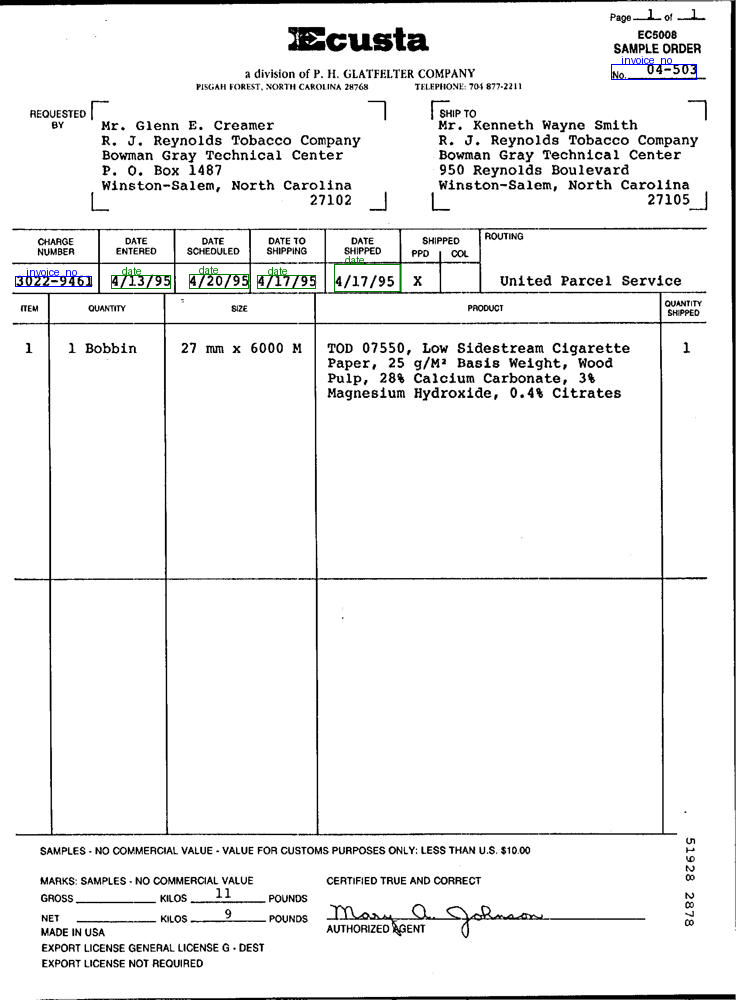

In [41]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {'invoice_no':'blue', 'date':'green', 'amount':'orange'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

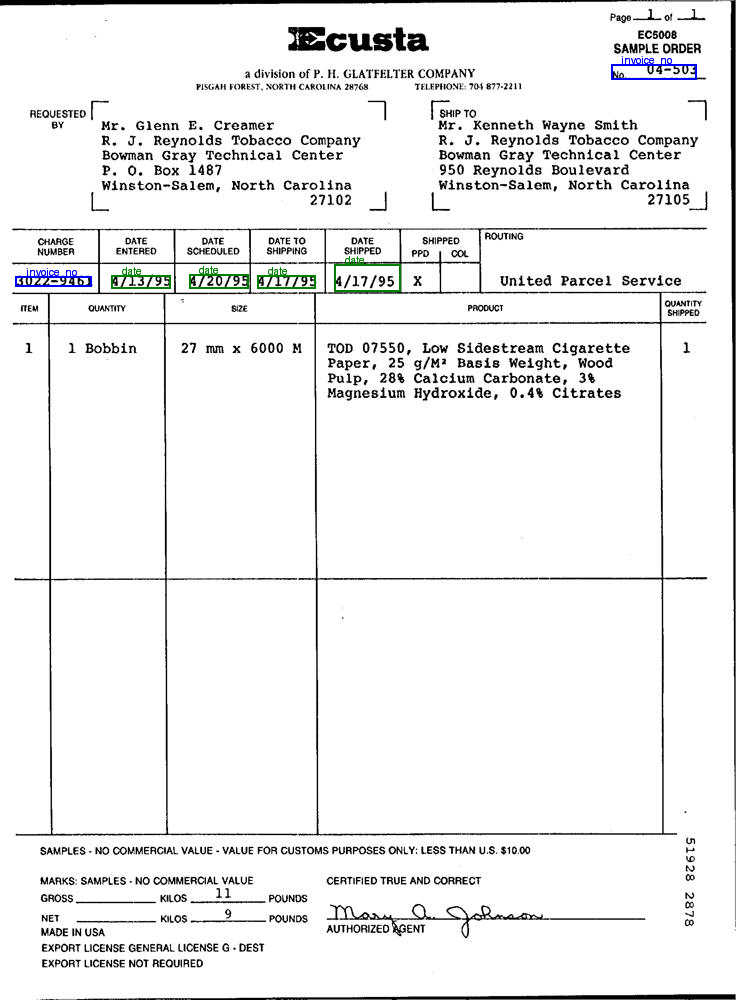

In [42]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image